# Product Sentiment Analysis


In this notebook we will be doing sentiment analysis in python using two different techniques:
1. VADER (Valence Aware Dictionary and sEntiment Reasoner) - Bag of words approach
2. Roberta Pretrained Model from 🤗
3. Huggingface Pipeline

# Step 0. Read in Data and NLTK Basics

In [158]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

plt.style.use('ggplot')

import nltk # type: ignore

In [159]:
# Read in data
df = pd.read_csv('../data/raw/training.csv')
df.columns = ['Review_UID', 'Product', 'Sentiment', 'Review']
print(df.shape)
df.info()

(74681, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74681 entries, 0 to 74680
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Review_UID  74681 non-null  int64 
 1   Product     74681 non-null  object
 2   Sentiment   74681 non-null  object
 3   Review      73995 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [160]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Review_UID,74681.0,6432.640149,3740.423819,1.0,3195.0,6422.0,9601.0,13200.0


## Quick EDA

In [161]:
# Type of column B before converting
print("Type of column B before converting: ", df['Review'].dtype)

# Convert column 'B' from object to string
df['Review'] = df['Review'].astype("string")
# Type of column B after converting
print("Type of column Review after converting: ", df['Review'].dtype)

Type of column B before converting:  object
Type of column Review after converting:  string


In [162]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74681 entries, 0 to 74680
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Review_UID  74681 non-null  int64 
 1   Product     74681 non-null  object
 2   Sentiment   74681 non-null  object
 3   Review      73995 non-null  string
dtypes: int64(1), object(2), string(1)
memory usage: 2.3+ MB


In [163]:
#df['Review_wordCount'] = df['Review'].apply(lambda x : len(x.split()))
#df['Review_charCount'] = df['Review'].apply(lambda x : len(x))


In [164]:
df

,Review_UID,Product,Sentiment,Review
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...
...,...,...,...,...
74676,9200,Nvidia,Positive,Just realized that the Windows partition of my...
74677,9200,Nvidia,Positive,Just realized that my Mac window partition is ...
74678,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...
74679,9200,Nvidia,Positive,Just realized between the windows partition of...


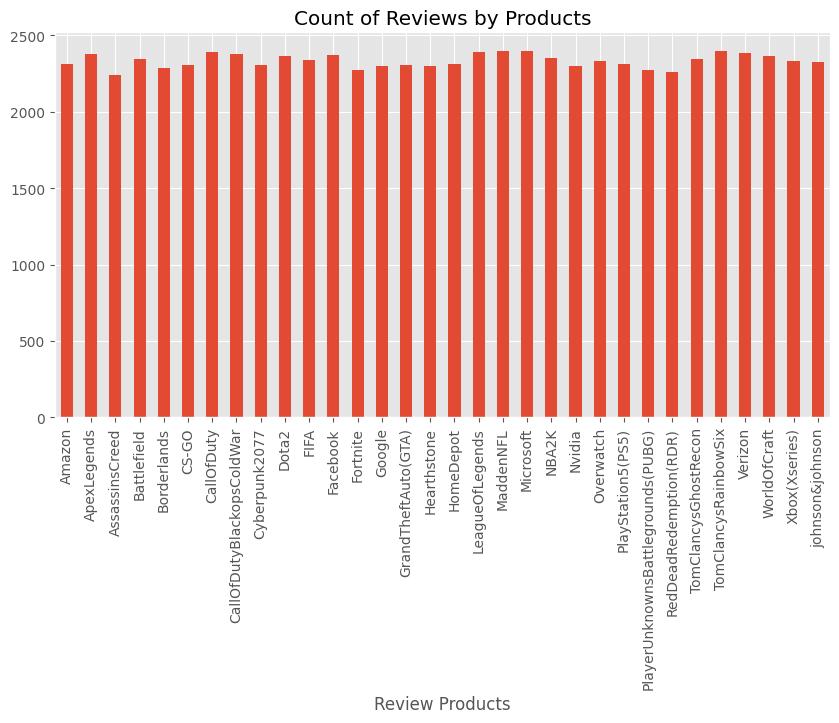

In [165]:
ax = df['Product'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Products',
          figsize=(10, 5))
ax.set_xlabel('Review Products')
plt.show()

## Data Cleaning
##### Steps of preprocessing
##### 1. Tokenization
##### 2. Normalization
#####   converting all text to the same case (upper or lower), removing punctuation, converting numbers to their word equivalents, and so on. Normalization puts all words on equal footing, and allows processing to proceed uniformly.
#####       set all characters to lowercase
#####       remove numbers (or convert numbers to textual representations)
#####       remove punctuation (generally part of tokenization, but still worth keeping in mind at this stage, even as confirmation)
#####       strip white space (also generally part of tokenization)
#####       remove default stop words (general English stop words)
##### Boradly:
#####   a. Stemming
#####   b. lemmitization
#####   c. everything else, 
##### 3. Noise Removal
#####   


In [166]:
### Checking Missing values in the Data Set and printing the Percentage for Missing Values for Each Columns ###

count = df.isnull().sum().sort_values(ascending=False)
percentage = ((df.isnull().sum()/len(df)*100)).sort_values(ascending=False)
missing_data = pd.concat([count, percentage], axis=1,
keys=['Count','Percentage'])

print('Count and percentage of missing values for the columns:')

missing_data

Count and percentage of missing values for the columns:


,Count,Percentage
Review,686,0.918574
Review_UID,0,0.000000
Product,0,0.000000
Sentiment,0,0.000000


In [167]:
print(df.shape)
df.info()

(74681, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74681 entries, 0 to 74680
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Review_UID  74681 non-null  int64 
 1   Product     74681 non-null  object
 2   Sentiment   74681 non-null  object
 3   Review      73995 non-null  string
dtypes: int64(1), object(2), string(1)
memory usage: 2.3+ MB


In [168]:
#Drop Rows with null columns
df.dropna(subset=['Review'], inplace=True)

In [169]:
print(df.shape)
df.info()

(73995, 4)
<class 'pandas.core.frame.DataFrame'>
Index: 73995 entries, 0 to 74680
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Review_UID  73995 non-null  int64 
 1   Product     73995 non-null  object
 2   Sentiment   73995 non-null  object
 3   Review      73995 non-null  string
dtypes: int64(1), object(2), string(1)
memory usage: 2.8+ MB


In [170]:
df = df.drop_duplicates()

In [171]:
print(df.shape)
df.info()

(71655, 4)
<class 'pandas.core.frame.DataFrame'>
Index: 71655 entries, 0 to 74680
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Review_UID  71655 non-null  int64 
 1   Product     71655 non-null  object
 2   Sentiment   71655 non-null  object
 3   Review      71655 non-null  string
dtypes: int64(1), object(2), string(1)
memory usage: 2.7+ MB


Percentage for default

Sentiment
Negative      30.28
Positive      27.51
Neutral       24.71
Irrelevant    17.50
Name: proportion, dtype: float64


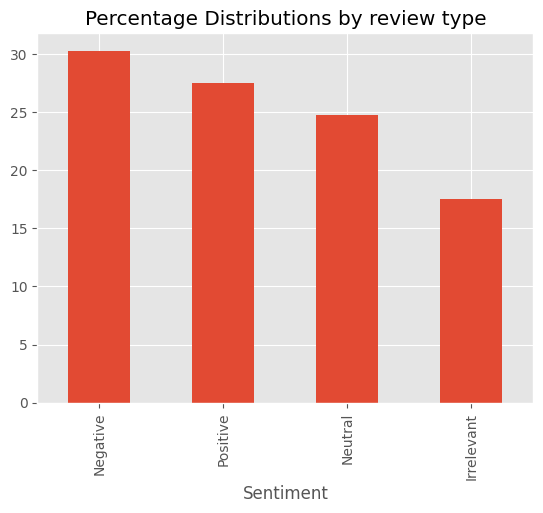

In [172]:
### Checking for the Distribution of Default ###
import matplotlib.pyplot as plt
%matplotlib inline
print('Percentage for default\n')
print(round(df.Sentiment.value_counts(normalize=True)*100,2))
round(df.Sentiment.value_counts(normalize=True)*100,2).plot(kind='bar')
plt.title('Percentage Distributions by review type')
plt.show()

# Visualizing Sentiments

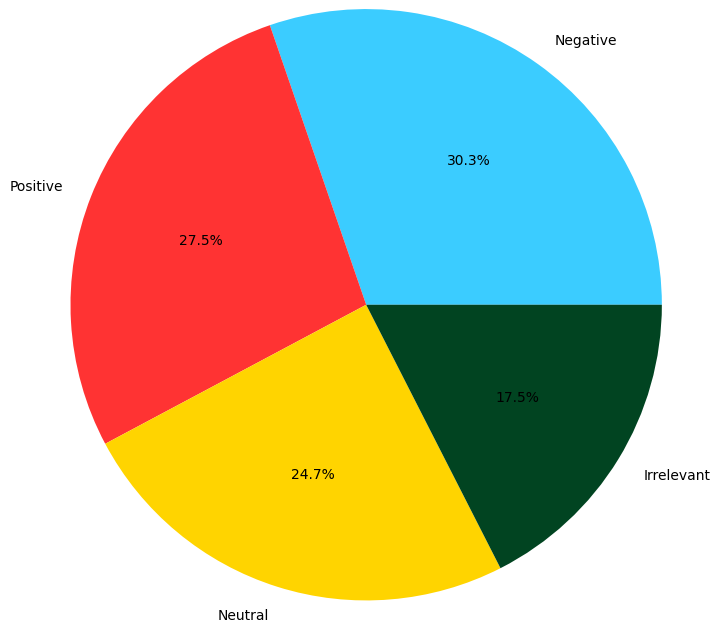

In [173]:
scores = df['Sentiment'].value_counts()

plt.pie(df['Sentiment'].value_counts(), 
        labels=scores.index, 
        autopct='%1.1f%%', 
        radius=2, 
        colors=['#3bccff','#ff3333', '#ffd400','#014421'])
plt.show()

In [174]:
# Apply first level cleaning
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import string

nltk.download('stopwords')

stemmer = nltk.SnowballStemmer('english')
stopword = set(stopwords.words('english'))

#This function converts to lower-case, removes square bracket, removes numbers and punctuation
def text_clean(text):
    #Basics
    text = text.lower() # transform text to lowercase
    text = re.sub('\[.*?\]', '', text) # remove '[]' and words in it
    text = re.sub('https?://\S+|www\.\S+', '', text) # remove links
    text = re.sub('<.*?>+', '', text) # remove '<>' and words in it
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)  #remove punctuation
    text = re.sub('[‘’“”…]', '', text) # remove "" and words in it
    text = re.sub('\n', '', text) # remove line feeds
    text = re.sub('\w*\d\w*', '', text) # remove numbers and words with numbers
    #Intermediate
    text = [word for word in text.split(' ') if word not in stopword] # remove stopwords
    text = [stemmer.stem(word) for word in text] # stem the text
    text=" ".join(text) # put words back together to form a text
    return text

cleaned1 = lambda x: text_clean_1(x)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vbiswas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [175]:
# Let's take a look at the updated text
df['cleaned_review'] = pd.DataFrame(df.Review.apply(cleaned1))
df.head(50)

,Review_UID,Product,Sentiment,Review,cleaned_review
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,i am coming to the borders and i will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,im getting on borderlands and i will kill you all
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,im getting on borderlands and i will murder y...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...,im getting into borderlands and i can murder y...
5,2402,Borderlands,Positive,So I spent a few hours making something for fu...,so i spent a few hours making something for fu...
6,2402,Borderlands,Positive,So I spent a couple of hours doing something f...,so i spent a couple of hours doing something f...
7,2402,Borderlands,Positive,So I spent a few hours doing something for fun...,so i spent a few hours doing something for fun...
8,2402,Borderlands,Positive,So I spent a few hours making something for fu...,so i spent a few hours making something for fu...
9,2402,Borderlands,Positive,2010 So I spent a few hours making something f...,so i spent a few hours making something for f...


## Model training 

In [176]:
from sklearn.model_selection import train_test_split

Independent_var = df.cleaned_review
Dependent_var = df.Sentiment

IV_train, IV_test, DV_train, DV_test = train_test_split(Independent_var, Dependent_var, test_size = 0.1, random_state = 225)

print('IV_train :', len(IV_train))
print('IV_test  :', len(IV_test))
print('DV_train :', len(DV_train))
print('DV_test  :', len(DV_test))


IV_train : 64489
IV_test  : 7166
DV_train : 64489
DV_test  : 7166


In [177]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

tvec = TfidfVectorizer()
clf2 = LogisticRegression(solver = "lbfgs")


from sklearn.pipeline import Pipeline

In [178]:
model = Pipeline([('vectorizer',tvec),('classifier',clf2)])

model.fit(IV_train, DV_train)


from sklearn.metrics import confusion_matrix

predictions = model.predict(IV_test)

confusion_matrix(predictions, DV_test)

array([[ 782,   75,   81,   76],
       [ 175, 1745,  186,  190],
       [ 140,  149, 1259,  176],
       [ 191,  145,  241, 1555]])

# Model Prediction 

In [179]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

print("Accuracy : ", accuracy_score(predictions, DV_test))
print("Precision : ", precision_score(predictions, DV_test, average = 'weighted'))
print("Recall : ", recall_score(predictions, DV_test, average = 'weighted'))

Accuracy :  0.7453251465252582
Precision :  0.7534687442513038
Recall :  0.7453251465252582


In [180]:
example = ["The professional dota 2 scene is fucking exploding and I completely welcome it."]
result = model.predict(example)

print(result)

['Positive']
